# PG Fixed evader trajectory, fixed pursuer initial position with Multiple Intermediate points

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

import torch
from torch import optim

from random import choice

print(sys.version)
print(torch.__version__)
print(torch.version.cuda)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

3.9.5 (default, May 11 2021, 08:20:37) 
[GCC 10.3.0]
1.9.0+cpu
None
cpu


## Environment

In [2]:
from environment import Environment

sel_env = 1
res = 1

env_file = open('Env'+str(sel_env)+'_res'+str(res)+'.txt', 'r')
env_head = np.fromstring(env_file.readline(), dtype=np.int32, sep=' ')
env_file.close()

env = Environment(env_head, device)

## Training initial states selection

In [3]:
initial_states = []
initial_states.append( np.array([1.5,1.5,0.5,0.5]) )
initial_states.append( np.array([3.5,1.5,2.5,0.5]) )
initial_states.append( np.array([3.5,4.5,3.5,2.5]) )
initial_states.append( np.array([3.5,7.5,3.5,5.5]) )
initial_states.append( np.array([1.5,7.5,3.5,7.5]) )
initial_states.append( np.array([1.5,4.5,1.5,6.5]) )

# initial_states.append( np.array([1.5,1.5,0.5,0.5]) )
# initial_states.append( np.array([3.5,1.5,2.5,0.5]) )
# initial_states.append( np.array([3.5,4.5,3.5,2.5]) )
# initial_states.append( np.array([3.5,7.5,3.5,5.5]) )
# initial_states.append( np.array([1.5,7.5,3.5,7.5]) )
# initial_states.append( np.array([1.5,4.5,1.5,6.5]) )

print(len(initial_states))
print(initial_states)

6
[array([1.5, 1.5, 0.5, 0.5]), array([3.5, 1.5, 2.5, 0.5]), array([3.5, 4.5, 3.5, 2.5]), array([3.5, 7.5, 3.5, 5.5]), array([1.5, 7.5, 3.5, 7.5]), array([1.5, 4.5, 1.5, 6.5])]


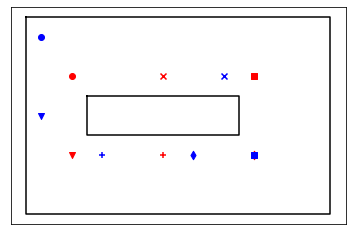

In [7]:
from obstacles import obstacles_per_env, border_per_env
border = border_per_env(sel_env)
obs = obstacles_per_env(sel_env)

border_x = []
border_y = []
for ver in border.vertices:
    border_x.append(ver.y)
    border_y.append(-ver.x)
border_x.append(border.vertices[0].y)
border_y.append(-border.vertices[0].x)

initial_states_array = np.array(initial_states)

ey = -initial_states_array[:,0]
ex = initial_states_array[:,1]
py = -initial_states_array[:,2]
px = initial_states_array[:,3]

my_markers = ['o', 'v', '+', 'd', 's', 'x', '*']
for i in range(len(initial_states)):
    plt.scatter(ex[i], ey[i], c='red', marker=my_markers[i])
    plt.scatter(px[i], py[i], c='blue', marker=my_markers[i])

plt.plot(border_x, border_y, 'k')
for ob in obs:
    ob_x = []
    ob_y = []
    
    for ver in ob.vertices:
        ob_x.append(ver.y)
        ob_y.append(-ver.x)
    ob_x.append(ob.vertices[0].y)
    ob_y.append(-ob.vertices[0].x)

    plt.plot(ob_x, ob_y, 'k')
plt.grid(True)
plt.xticks([])
plt.yticks([])
plt.show()

## Create fully connected network

In [5]:
from models import pursuer_NN
pursuer_model_training  = pursuer_NN(input_size=4, n_actions=5, num_neurons_hidden=256, device=device).to(device)
pursuer_model           = pursuer_NN(input_size=4, n_actions=5, num_neurons_hidden=256, device=device).to(device)

In [6]:
def discount_rewards(rewards, gamma=0.99):
    r = np.array([gamma**i * rewards[i] for i in range(len(rewards))])

    # Reverse the array direction for cumsum and then
    # revert back to the original order
    r = r[::-1].cumsum()[::-1]

    return r#(r - r.mean())# / (r.std() + np.finfo(np.float32).eps)

In [7]:
def REINFORCE_PURSUER_FIXED(total_trajectories=2000, gamma=0.99, lr=0.001, batch_size=8, MAX_EPSILON = 1.0, MIN_EPSILON = 0.1, DECAY_RATE = 0.001):
    # Set up lists to hold results
    train_rewards  = []
    train_rewards.append(0)
    test_rewards   = []
    test_rewards.append(0)
    test_episodes  = []
    test_episodes.append(0)

    batch_states            = []
    batch_rewards           = []
    batch_total_rewards     = []
    batch_discount_actions  = []
    batch_counter           = 0


    optimizer = optim.Adam(pursuer_model_training.parameters(), lr=lr)

    initial_states_index = 0
    for ep in range(total_trajectories):
        s_0 = initial_states_array[initial_states_index]
        env.state = s_0

        initial_states_index += 1
        if initial_states_index >= batch_size: initial_states_index = 0

        states          = []
        actions         = []
        rewards         = []

        done = False
        t = 0
        while not done:
            p_dist = pursuer_model_training(s_0).detach().cpu().numpy()

            epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-DECAY_RATE * ep)
            s_1, r, done, a_p = env.step_training(p_dist, t, epsilon)
            
            states.append(s_0)
            rewards.append(r)
            actions.append(a_p)

            t += 1
            s_0 = s_1

            if done:
                batch_states.extend(states)
                batch_rewards.extend(discount_rewards(rewards, gamma))
                batch_total_rewards.append(sum(rewards))
                batch_discount_actions.extend(actions)

                batch_counter += 1

                if batch_counter ==  batch_size:
                    optimizer.zero_grad()

                    state_tensor    = torch.FloatTensor(batch_states)
                    reward_tensor   = torch.FloatTensor(batch_rewards).to(device)
                    action_tensor   = torch.LongTensor(batch_discount_actions)

                    # Calculate loss
                    logprob             = torch.log(pursuer_model_training(state_tensor)).to(device)
                    selected_logprobs   = reward_tensor * logprob[np.arange(len(action_tensor)), action_tensor]
                    loss                = -selected_logprobs.mean()

                    # Calculate gradients
                    loss.backward()

                    # Apply gradients
                    optimizer.step()

                    batch_rewards   = []
                    batch_discount_actions   = []
                    batch_states    = []
                    batch_counter   = 0

                    # Test the neural network with the best action
                    s_0 = env.reset_fixed_initial_position()
                    rewards_test = 0
                    done = False
                    t = 0
                    while not done:
                        p_dist = pursuer_model_training(s_0).detach().cpu().numpy()
                        s_1, r, done, _ = env.step_best_action(p_dist, t)
                        rewards_test += r
                        t += 1
                        s_0 = s_1

                    if rewards_test > test_rewards[-1]:
                        pursuer_model.load_state_dict(pursuer_model_training.state_dict())
                        test_rewards.append(rewards_test)
                    else:
                        test_rewards.append(test_rewards[-1])

                    train_rewards.append(np.mean(batch_total_rewards))
                    
                    batch_total_rewards = []
                    test_episodes.append(ep)

                    print('\rEp: {}, average training rewards {:.4f}, test rewards {:.4f}'.format(ep+1, train_rewards[-1], test_rewards[-1]), end='')

    return test_episodes, train_rewards, test_rewards

In [8]:
test_episodes, train_rewards, test_rewards = REINFORCE_PURSUER_FIXED(total_trajectories=12000, batch_size=len(initial_states), lr=0.0005)

Ep: 12000, average training rewards 6.2500, test rewards 18.0000

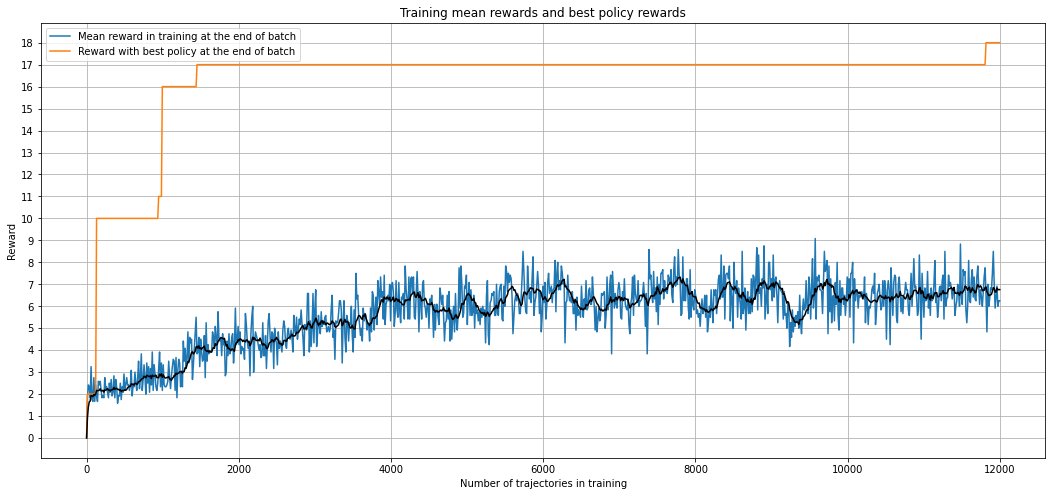

In [9]:
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(1, 1, 1)
plt.plot(test_episodes, train_rewards, label='Mean reward in training at the end of batch')
plt.plot(test_episodes, test_rewards, label='Reward with best policy at the end of batch')

window = 10
smoothed_train_rewards = [np.mean(train_rewards[i-window:i+1]) if i > window 
                    else np.mean(train_rewards[:i+1]) for i in range(len(train_rewards))]
plt.plot(test_episodes, smoothed_train_rewards, 'k')

plt.xlabel('Number of trajectories in training')
plt.ylabel('Reward')
plt.title('Training mean rewards and best policy rewards')
plt.legend()
#grid
yticks = np.linspace(0, test_rewards[-1], test_rewards[-1]+1)
ax.set_yticks(yticks)
plt.grid()
plt.savefig('pursuer_fixed_initial_position_MPI_' + str(sel_env) + '.png')
plt.show()

In [10]:
torch.save(pursuer_model,  'pursuer_RL_MPI_Env' + str(sel_env) + '_res' + str(res) + '.pt')
torch.save(pursuer_model.state_dict(),  'pursuer_dict_RL_MPI_Env' + str(sel_env) + '_res' + str(res) + '.pt')

np.savetxt('pursuer_RL_Env' + str(sel_env) + '_res' + str(res) + '_train_rewrds_e-greedy_MPI.txt', train_rewards, fmt='%.4f')
np.savetxt('pursuer_RL_Env' + str(sel_env) + '_res' + str(res) + '_test_rewrdse-greedy_MPI.txt', test_rewards, fmt='%.4f')